<a href="https://colab.research.google.com/github/andrillion/test/blob/main/nurse_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scheduling of nurses to shifts

In [1]:
!pip install -q ortools
!pip install -q typing
!pip install -q matplotlib
!pip install -q seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 12.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.26.1 which is incompatible.
tensorflow-metadata 1.13.1 requires absl-py<2.0.0,>=0.9, but you have absl-py 2.1.0 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 5.26.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Day 1:
  Shift 1: Nurses [1, 5]
  Shift 2: Nurses [2, 8]
  Shift 3: Nurses [7, 9]
Day 2:
  Shift 1: Nurses [3, 6]
  Shift 2: Nurses [1, 7]
  Shift 3: Nurses [0, 8]
Day 3:
  Shift 1: Nurses [2, 9]
  Shift 2: Nurses [0, 6]
  Shift 3: Nurses [1, 5]
Day 4:
  Shift 1: Nurses [4, 6]
  Shift 2: Nurses [8, 9]
  Shift 3: Nurses [2, 3]
Day 5:
  Shift 1: Nurses [1, 5]
  Shift 2: Nurses [0, 4]
  Shift 3: Nurses [6, 7]
Day 6:
  Shift 1: Nurses [2, 3]
  Shift 2: Nurses [5, 6]
  Shift 3: Nurses [0, 4]
Day 7:
  Shift 1: Nurses [1, 5]
  Shift 2: Nurses [7, 8]
  Shift 3: Nurses [3, 9]


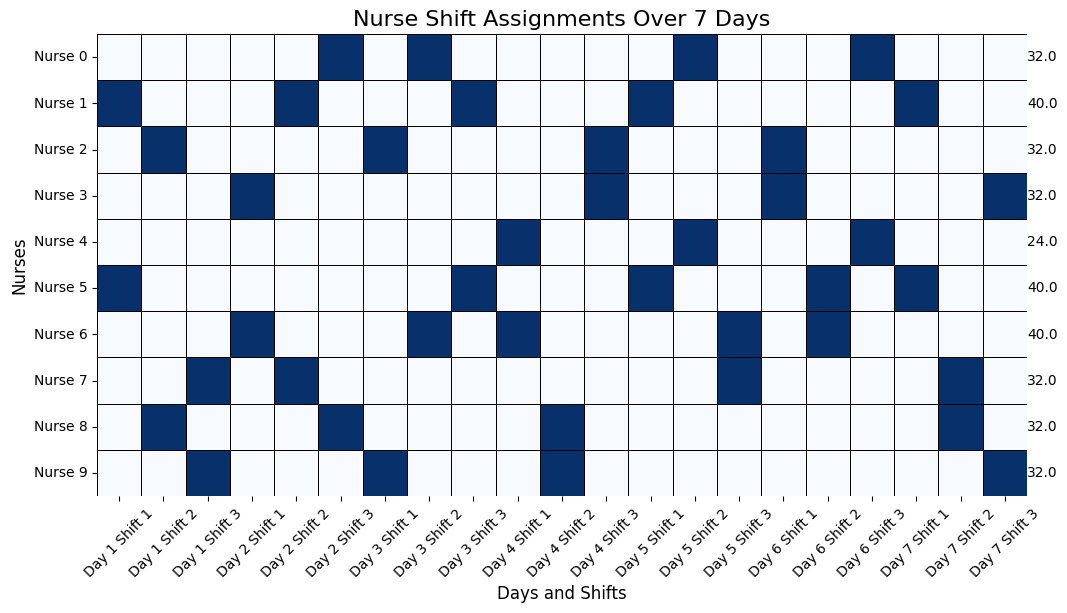

In [ ]:
from ortools.sat.python import cp_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def main():
    model = cp_model.CpModel()

    # Parameters
    num_nurses = 10
    num_days = 7
    num_shifts = 3

    # Creating variables
    shifts = {}
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts):
                shifts[(n, d, s)] = model.NewBoolVar(f'shift_n{n}_d{d}_s{s}')

    # Each shift must have exactly 2 nurses assigned
    for d in range(num_days):
        for s in range(num_shifts):
            model.Add(sum(shifts[(n, d, s)] for n in range(num_nurses)) == 2)

    # Each nurse can work at most one shift per day
    for n in range(num_nurses):
        for d in range(num_days):
            model.Add(sum(shifts[(n, d, s)] for s in range(num_shifts)) <= 1)

    # Each nurse should have at least one shift rest between two working shifts
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts - 1):  # Check for shifts within the same day
                model.Add(shifts[(n, d, s)] + shifts[(n, d, s + 1)] <= 1)  # Cannot work two consecutive shifts on the same day

    # Additional constraint: If a nurse works night shift (shift 3) on day d,
    # they cannot work morning shift (shift 1) on day d + 1
    for n in range(num_nurses):
        for d in range(num_days - 1):  # Loop until the second last day
            model.Add(shifts[(n, d, 2)] + shifts[(n, d + 1, 0)] <= 1)  # Night shift on day d and morning shift on day d+1

    # Preventing nurses from working the same shift on consecutive days
    for n in range(num_nurses):
        for d in range(num_days - 1):
            for s in range(num_shifts):
                model.Add(shifts[(n, d, s)] + shifts[(n, d + 1, s)] <= 1)  # Same shift on consecutive days

    # New constraint: Each nurse can work a maximum of 5 shifts per week
    for n in range(num_nurses):
        model.Add(sum(shifts[(n, d, s)] for d in range(num_days) for s in range(num_shifts)) <= 5)

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Initialize heatmap data
        heatmap_data = np.zeros((num_nurses, num_days * num_shifts))

        # Calculate total hours for each nurse
        total_hours = np.zeros(num_nurses)

        for d in range(num_days):
            print(f'Day {d + 1}:')
            for s in range(num_shifts):
                assigned_nurses = [n for n in range(num_nurses) if solver.Value(shifts[(n, d, s)]) == 1]
                print(f'  Shift {s + 1}: Nurses {assigned_nurses}')

                # Fill the heatmap data
                for nurse in assigned_nurses:
                    heatmap_data[nurse, d * num_shifts + s] = 1  # Mark the nurse as working
                    total_hours[nurse] += 8  # Each shift is 8 hours

        # Create the heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

        # Add labels
        plt.title('Nurse Shift Assignments Over 7 Days', fontsize=16)
        plt.xlabel('Days and Shifts', fontsize=12)
        plt.ylabel('Nurses', fontsize=12)
        plt.xticks(ticks=np.arange(num_days * num_shifts) + 0.5,
                   labels=[f'Day {i // 3 + 1} Shift {i % 3 + 1}' for i in range(num_days * num_shifts)],
                   rotation=45)
        plt.yticks(ticks=np.arange(num_nurses) + 0.5,
                   labels=[f'Nurse {i}' for i in range(num_nurses)],
                   rotation=0)

        # Annotate total hours worked on the heatmap
        for i in range(num_nurses):
            plt.text(num_days * num_shifts, i + 0.5, f'{total_hours[i]}', va='center', ha='left')

        plt.show()
    else:
        print('No solution found!')

if __name__ == "__main__":
    main()


Day 1:
  Shift 1: Nurses [7, 8]
  Shift 2: Nurses [0, 6]
  Shift 3: Nurses [3, 5]
Day 2:
  Shift 1: Nurses [2, 4]
  Shift 2: Nurses [5, 8]
  Shift 3: Nurses [6, 7]
Day 3:
  Shift 1: Nurses [1, 8]
  Shift 2: Nurses [4, 9]
  Shift 3: Nurses [2, 3]
Day 4:
  Shift 1: Nurses [4, 9]
  Shift 2: Nurses [3, 8]
  Shift 3: Nurses [6, 7]
Day 5:
  Shift 1: Nurses [0, 2]
  Shift 2: Nurses [7, 9]
  Shift 3: Nurses [3, 5]
Day 6:
  Shift 1: Nurses [1, 9]
  Shift 2: Nurses [2, 6]
  Shift 3: Nurses [0, 4]
Day 7:
  Shift 1: Nurses [6, 7]
  Shift 2: Nurses [1, 3]
  Shift 3: Nurses [5, 9]


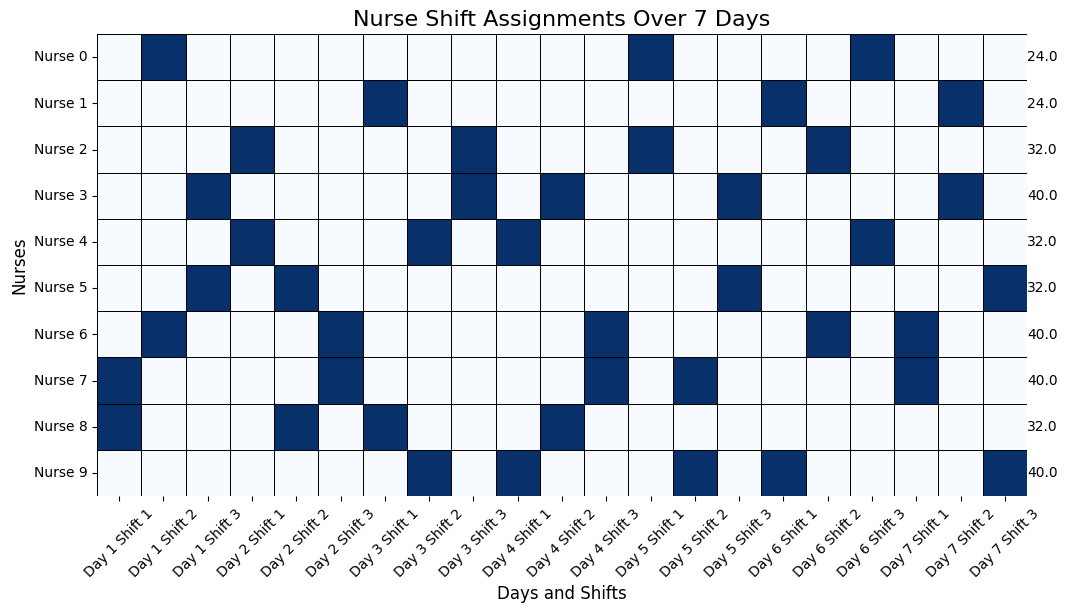

In [4]:

from ortools.sat.python import cp_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def main():
    model = cp_model.CpModel()

    # Parameters
    num_nurses = 10
    num_days = 7
    num_shifts = 3

    # Specify max shifts per nurse (for example, 5 for full-time, 3 for part-time)
    max_shifts_per_nurse = [3, 3, 5, 5, 5, 4, 5, 5, 4, 5]  # Customize this list as needed

    # Creating variables
    shifts = {}
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts):
                shifts[(n, d, s)] = model.NewBoolVar(f'shift_n{n}_d{d}_s{s}')

    # Each shift must have exactly 2 nurses assigned
    for d in range(num_days):
        for s in range(num_shifts):
            model.Add(sum(shifts[(n, d, s)] for n in range(num_nurses)) == 2)

    # Each nurse can work at most one shift per day
    for n in range(num_nurses):
        for d in range(num_days):
            model.Add(sum(shifts[(n, d, s)] for s in range(num_shifts)) <= 1)

    # Each nurse should have at least one shift rest between two working shifts
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts - 1):
                model.Add(shifts[(n, d, s)] + shifts[(n, d, s + 1)] <= 1)

    # If a nurse works night shift (shift 3) on day d, they cannot work morning shift on day d + 1
    for n in range(num_nurses):
        for d in range(num_days - 1):
            model.Add(shifts[(n, d, 2)] + shifts[(n, d + 1, 0)] <= 1)

    # Preventing nurses from working the same shift on consecutive days
    for n in range(num_nurses):
        for d in range(num_days - 1):
            for s in range(num_shifts):
                model.Add(shifts[(n, d, s)] + shifts[(n, d + 1, s)] <= 1)

    # New constraint: Limit the total number of shifts each nurse can work per week
    for n in range(num_nurses):
        model.Add(sum(shifts[(n, d, s)] for d in range(num_days) for s in range(num_shifts)) <= max_shifts_per_nurse[n])

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Initialize heatmap data
        heatmap_data = np.zeros((num_nurses, num_days * num_shifts))

        # Calculate total hours for each nurse
        total_hours = np.zeros(num_nurses)

        for d in range(num_days):
            print(f'Day {d + 1}:')
            for s in range(num_shifts):
                assigned_nurses = [n for n in range(num_nurses) if solver.Value(shifts[(n, d, s)]) == 1]
                print(f'  Shift {s + 1}: Nurses {assigned_nurses}')

                # Fill the heatmap data
                for nurse in assigned_nurses:
                    heatmap_data[nurse, d * num_shifts + s] = 1  # Mark the nurse as working
                    total_hours[nurse] += 8  # Each shift is 8 hours

        # Create the heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

        # Add labels
        plt.title('Nurse Shift Assignments Over 7 Days', fontsize=16)
        plt.xlabel('Days and Shifts', fontsize=12)
        plt.ylabel('Nurses', fontsize=12)
        plt.xticks(ticks=np.arange(num_days * num_shifts) + 0.5,
                   labels=[f'Day {i // 3 + 1} Shift {i % 3 + 1}' for i in range(num_days * num_shifts)],
                   rotation=45)
        plt.yticks(ticks=np.arange(num_nurses) + 0.5,
                   labels=[f'Nurse {i}' for i in range(num_nurses)],
                   rotation=0)

        # Annotate total hours worked on the heatmap
        for i in range(num_nurses):
            plt.text(num_days * num_shifts, i + 0.5, f'{total_hours[i]}', va='center', ha='left')

        plt.show()
    else:
        print('No solution found!')

if __name__ == "__main__":
    main()



## Test with more days

Day 1:
  Shift 1: Nurses [3, 7, 17, 18]
  Shift 2: Nurses [6, 9, 13, 19]
  Shift 3: Nurses [1, 4, 5, 16]
Day 2:
  Shift 1: Nurses [9, 10, 12, 15]
  Shift 2: Nurses [4, 5, 8, 17]
  Shift 3: Nurses [0, 13, 14, 18]
Day 3:
  Shift 1: Nurses [4, 6, 7, 19]
  Shift 2: Nurses [0, 13, 14, 16]
  Shift 3: Nurses [3, 5, 9, 17]
Day 4:
  Shift 1: Nurses [1, 14, 15, 18]
  Shift 2: Nurses [2, 5, 6, 11]
  Shift 3: Nurses [4, 7, 10, 16]
Day 5:
  Shift 1: Nurses [3, 5, 12, 19]
  Shift 2: Nurses [0, 7, 9, 15]
  Shift 3: Nurses [2, 6, 8, 14]
Day 6:
  Shift 1: Nurses [10, 11, 15, 17]
  Shift 2: Nurses [3, 13, 14, 19]
  Shift 3: Nurses [1, 7, 9, 16]
Day 7:
  Shift 1: Nurses [2, 3, 13, 19]
  Shift 2: Nurses [6, 11, 16, 17]
  Shift 3: Nurses [4, 8, 12, 15]
Day 8:
  Shift 1: Nurses [9, 11, 14, 17]
  Shift 2: Nurses [3, 8, 12, 19]
  Shift 3: Nurses [5, 7, 10, 16]
Day 9:
  Shift 1: Nurses [2, 4, 6, 13]
  Shift 2: Nurses [5, 7, 9, 15]
  Shift 3: Nurses [3, 11, 14, 19]
Day 10:
  Shift 1: Nurses [5, 7, 9, 16]
  Shif

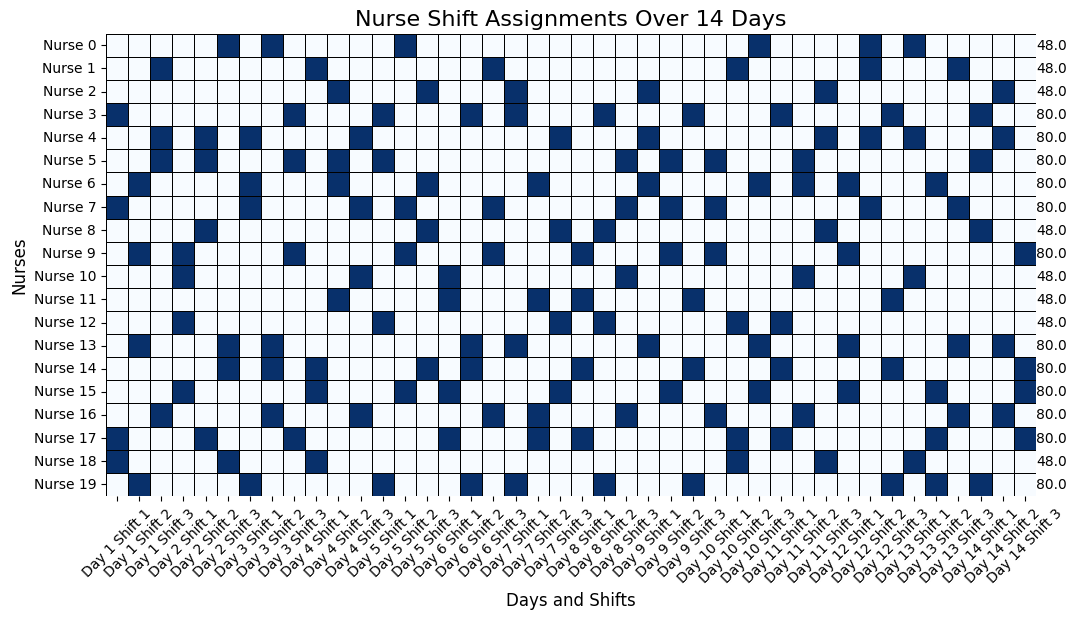

In [15]:
from ortools.sat.python import cp_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def main():
    model = cp_model.CpModel()

    # Parameters
    num_nurses = 20
    num_days = 14  # Extend to 14 days
    num_shifts = 3  # Number of shifts per day

    # Specify max shifts per nurse per week (for example, 5 for full-time, 3 for part-time)
    max_shifts_per_nurse = [3, 3, 3, 5, 5, 5, 5, 5, 3, 5, 3, 3, 3, 5, 5, 5, 5, 5, 3, 5] # Customize this list as needed

    # Creating variables
    shifts = {}
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts):
                shifts[(n, d, s)] = model.NewBoolVar(f'shift_n{n}_d{d}_s{s}')

    # Each shift must have exactly 2 nurses assigned
    for d in range(num_days):
        for s in range(num_shifts):
            model.Add(sum(shifts[(n, d, s)] for n in range(num_nurses)) == 4)  # Change to 4 nurses per shift

    # Each nurse can work at most one shift per day
    for n in range(num_nurses):
        for d in range(num_days):
            model.Add(sum(shifts[(n, d, s)] for s in range(num_shifts)) <= 1)

    # Each nurse should have at least one shift rest between two working shifts
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts - 1):
                model.Add(shifts[(n, d, s)] + shifts[(n, d, s + 1)] <= 1)

    # If a nurse works night shift (shift 3) on day d, they cannot work morning shift on day d + 1
    for n in range(num_nurses):
        for d in range(num_days - 1):
            model.Add(shifts[(n, d, 2)] + shifts[(n, d + 1, 0)] <= 1)

    # Preventing nurses from working the same shift on consecutive days
    for n in range(num_nurses):
        for d in range(num_days - 1):
            for s in range(num_shifts):
                model.Add(shifts[(n, d, s)] + shifts[(n, d + 1, s)] <= 1)

    # New constraint: Limit the total number of shifts each nurse can work per week (split into two 7-day weeks)
    for n in range(num_nurses):
        model.Add(sum(shifts[(n, d, s)] for d in range(7) for s in range(num_shifts)) <= max_shifts_per_nurse[n])  # Week 1
        model.Add(sum(shifts[(n, d, s)] for d in range(7, 14) for s in range(num_shifts)) <= max_shifts_per_nurse[n])  # Week 2

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Initialize heatmap data
        heatmap_data = np.zeros((num_nurses, num_days * num_shifts))

        # Calculate total hours for each nurse
        total_hours = np.zeros(num_nurses)

        for d in range(num_days):
            print(f'Day {d + 1}:')
            for s in range(num_shifts):
                assigned_nurses = [n for n in range(num_nurses) if solver.Value(shifts[(n, d, s)]) == 1]
                print(f'  Shift {s + 1}: Nurses {assigned_nurses}')

                # Fill the heatmap data
                for nurse in assigned_nurses:
                    heatmap_data[nurse, d * num_shifts + s] = 1  # Mark the nurse as working
                    total_hours[nurse] += 8  # Each shift is 8 hours

        # Create the heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

        # Add labels
        plt.title('Nurse Shift Assignments Over 14 Days', fontsize=16)
        plt.xlabel('Days and Shifts', fontsize=12)
        plt.ylabel('Nurses', fontsize=12)
        plt.xticks(ticks=np.arange(num_days * num_shifts) + 0.5,
                   labels=[f'Day {i // 3 + 1} Shift {i % 3 + 1}' for i in range(num_days * num_shifts)],
                   rotation=45)
        plt.yticks(ticks=np.arange(num_nurses) + 0.5,
                   labels=[f'Nurse {i}' for i in range(num_nurses)],
                   rotation=0)

        # Annotate total hours worked on the heatmap
        for i in range(num_nurses):
            plt.text(num_days * num_shifts, i + 0.5, f'{total_hours[i]}', va='center', ha='left')

        plt.show()
    else:
        print('No solution found!')

if __name__ == "__main__":
    main()


Day 1:
  Shift 1: Nurses [3, 7, 17, 18]
  Shift 2: Nurses [6, 9, 13, 19]
  Shift 3: Nurses [1, 4, 5, 16]
Day 2:
  Shift 1: Nurses [9, 10, 12, 15]
  Shift 2: Nurses [4, 5, 8, 17]
  Shift 3: Nurses [0, 13, 14, 18]
Day 3:
  Shift 1: Nurses [4, 6, 7, 19]
  Shift 2: Nurses [0, 13, 14, 16]
  Shift 3: Nurses [3, 5, 9, 17]
Day 4:
  Shift 1: Nurses [1, 14, 15, 18]
  Shift 2: Nurses [2, 5, 6, 11]
  Shift 3: Nurses [4, 7, 10, 16]
Day 5:
  Shift 1: Nurses [3, 5, 12, 19]
  Shift 2: Nurses [0, 7, 9, 15]
  Shift 3: Nurses [2, 6, 8, 14]
Day 6:
  Shift 1: Nurses [10, 11, 15, 17]
  Shift 2: Nurses [3, 13, 14, 19]
  Shift 3: Nurses [1, 7, 9, 16]
Day 7:
  Shift 1: Nurses [2, 3, 13, 19]
  Shift 2: Nurses [6, 11, 16, 17]
  Shift 3: Nurses [4, 8, 12, 15]
Day 8:
  Shift 1: Nurses [9, 11, 14, 17]
  Shift 2: Nurses [3, 8, 12, 19]
  Shift 3: Nurses [5, 7, 10, 16]
Day 9:
  Shift 1: Nurses [2, 4, 6, 13]
  Shift 2: Nurses [5, 7, 9, 15]
  Shift 3: Nurses [3, 11, 14, 19]
Day 10:
  Shift 1: Nurses [5, 7, 9, 16]
  Shif

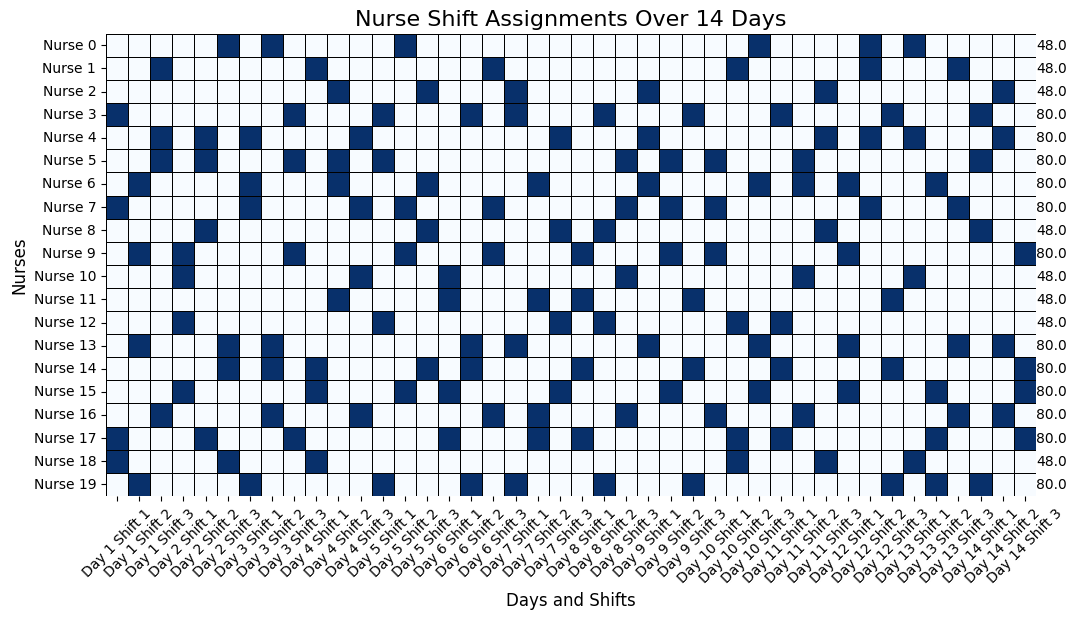


Nurse Schedules:
Nurse 0: Day 2 Shift 3, Day 3 Shift 2, Day 5 Shift 2, Day 10 Shift 3, Day 12 Shift 2, Day 13 Shift 1
Nurse 1: Day 1 Shift 3, Day 4 Shift 1, Day 6 Shift 3, Day 10 Shift 2, Day 12 Shift 2, Day 13 Shift 3
Nurse 2: Day 4 Shift 2, Day 5 Shift 3, Day 7 Shift 1, Day 9 Shift 1, Day 11 Shift 3, Day 14 Shift 2
Nurse 3: Day 1 Shift 1, Day 3 Shift 3, Day 5 Shift 1, Day 6 Shift 2, Day 7 Shift 1, Day 8 Shift 2, Day 9 Shift 3, Day 11 Shift 1, Day 12 Shift 3, Day 14 Shift 1
Nurse 4: Day 1 Shift 3, Day 2 Shift 2, Day 3 Shift 1, Day 4 Shift 3, Day 7 Shift 3, Day 9 Shift 1, Day 11 Shift 3, Day 12 Shift 2, Day 13 Shift 1, Day 14 Shift 2
Nurse 5: Day 1 Shift 3, Day 2 Shift 2, Day 3 Shift 3, Day 4 Shift 2, Day 5 Shift 1, Day 8 Shift 3, Day 9 Shift 2, Day 10 Shift 1, Day 11 Shift 2, Day 14 Shift 1
Nurse 6: Day 1 Shift 2, Day 3 Shift 1, Day 4 Shift 2, Day 5 Shift 3, Day 7 Shift 2, Day 9 Shift 1, Day 10 Shift 3, Day 11 Shift 2, Day 12 Shift 1, Day 13 Shift 2
Nurse 7: Day 1 Shift 1, Day 3 Shif

In [17]:
from ortools.sat.python import cp_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def main():
    model = cp_model.CpModel()

    # Parameters
    num_nurses = 20
    num_days = 14  # Extend to 14 days
    num_shifts = 3  # Number of shifts per day

    # Specify max shifts per nurse per week (for example, 5 for full-time, 3 for part-time)
    max_shifts_per_nurse = [3, 3, 3, 5, 5, 5, 5, 5, 3, 5, 3, 3, 3, 5, 5, 5, 5, 5, 3, 5]  # Customize this list as needed

    # Creating variables
    shifts = {}
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts):
                shifts[(n, d, s)] = model.NewBoolVar(f'shift_n{n}_d{d}_s{s}')

    # Each shift must have exactly 4 nurses assigned
    for d in range(num_days):
        for s in range(num_shifts):
            model.Add(sum(shifts[(n, d, s)] for n in range(num_nurses)) == 4)  # Change to 4 nurses per shift

    # Each nurse can work at most one shift per day
    for n in range(num_nurses):
        for d in range(num_days):
            model.Add(sum(shifts[(n, d, s)] for s in range(num_shifts)) <= 1)

    # Each nurse should have at least one shift rest between two working shifts
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts - 1):
                model.Add(shifts[(n, d, s)] + shifts[(n, d, s + 1)] <= 1)

    # If a nurse works night shift (shift 3) on day d, they cannot work morning shift on day d + 1
    for n in range(num_nurses):
        for d in range(num_days - 1):
            model.Add(shifts[(n, d, 2)] + shifts[(n, d + 1, 0)] <= 1)

    # Preventing nurses from working the same shift on consecutive days
    for n in range(num_nurses):
        for d in range(num_days - 1):
            for s in range(num_shifts):
                model.Add(shifts[(n, d, s)] + shifts[(n, d + 1, s)] <= 1)

    # New constraint: Limit the total number of shifts each nurse can work per week (split into two 7-day weeks)
    for n in range(num_nurses):
        model.Add(sum(shifts[(n, d, s)] for d in range(7) for s in range(num_shifts)) <= max_shifts_per_nurse[n])  # Week 1
        model.Add(sum(shifts[(n, d, s)] for d in range(7, 14) for s in range(num_shifts)) <= max_shifts_per_nurse[n])  # Week 2

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Initialize heatmap data
        heatmap_data = np.zeros((num_nurses, num_days * num_shifts))

        # Calculate total hours for each nurse
        total_hours = np.zeros(num_nurses)

        # Initialize the schedule for each nurse
        nurse_schedule = {n: [] for n in range(num_nurses)}

        for d in range(num_days):
            print(f'Day {d + 1}:')
            for s in range(num_shifts):
                assigned_nurses = [n for n in range(num_nurses) if solver.Value(shifts[(n, d, s)]) == 1]
                print(f'  Shift {s + 1}: Nurses {assigned_nurses}')

                # Fill the heatmap data
                for nurse in assigned_nurses:
                    heatmap_data[nurse, d * num_shifts + s] = 1  # Mark the nurse as working
                    total_hours[nurse] += 8  # Each shift is 8 hours

                    # Add to the nurse's schedule
                    nurse_schedule[nurse].append(f'Day {d + 1} Shift {s + 1}')

        # Create the heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

        # Add labels
        plt.title('Nurse Shift Assignments Over 14 Days', fontsize=16)
        plt.xlabel('Days and Shifts', fontsize=12)
        plt.ylabel('Nurses', fontsize=12)
        plt.xticks(ticks=np.arange(num_days * num_shifts) + 0.5,
                   labels=[f'Day {i // 3 + 1} Shift {i % 3 + 1}' for i in range(num_days * num_shifts)],
                   rotation=45)
        plt.yticks(ticks=np.arange(num_nurses) + 0.5,
                   labels=[f'Nurse {i}' for i in range(num_nurses)],
                   rotation=0)

        # Annotate total hours worked on the heatmap
        for i in range(num_nurses):
            plt.text(num_days * num_shifts, i + 0.5, f'{total_hours[i]}', va='center', ha='left')

        plt.show()

        # Print the schedule for each nurse
        print("\nNurse Schedules:")
        for nurse, schedule in nurse_schedule.items():
            print(f'Nurse {nurse}: {", ".join(schedule)}')

    else:
        print('No solution found!')

if __name__ == "__main__":
    main()


## 4 week schedule for 20 nurses

Nurse 0:
  Day 1: Off
  Day 2: Shift 1
  Day 3: Shift 2
  Day 4: Off
  Day 5: Shift 3
  Day 6: Off
  Day 7: Off
  Day 8: Off
  Day 9: Shift 1
  Day 10: Off
  Day 11: Off
  Day 12: Shift 1
  Day 13: Off
  Day 14: Shift 1
  Day 15: Shift 3
  Day 16: Off
  Day 17: Shift 3
  Day 18: Off
  Day 19: Shift 1
  Day 20: Off
  Day 21: Off
  Day 22: Shift 1
  Day 23: Shift 3
  Day 24: Off
  Day 25: Off
  Day 26: Shift 3
  Day 27: Off
  Day 28: Off
Nurse 1:
  Day 1: Off
  Day 2: Off
  Day 3: Shift 1
  Day 4: Shift 2
  Day 5: Shift 1
  Day 6: Off
  Day 7: Off
  Day 8: Off
  Day 9: Off
  Day 10: Shift 3
  Day 11: Off
  Day 12: Shift 3
  Day 13: Shift 2
  Day 14: Off
  Day 15: Shift 1
  Day 16: Shift 3
  Day 17: Off
  Day 18: Off
  Day 19: Off
  Day 20: Shift 2
  Day 21: Off
  Day 22: Off
  Day 23: Off
  Day 24: Shift 1
  Day 25: Off
  Day 26: Shift 1
  Day 27: Shift 3
  Day 28: Off
Nurse 2:
  Day 1: Off
  Day 2: Shift 3
  Day 3: Shift 2
  Day 4: Off
  Day 5: Off
  Day 6: Shift 2
  Day 7: Off
  Day 8:

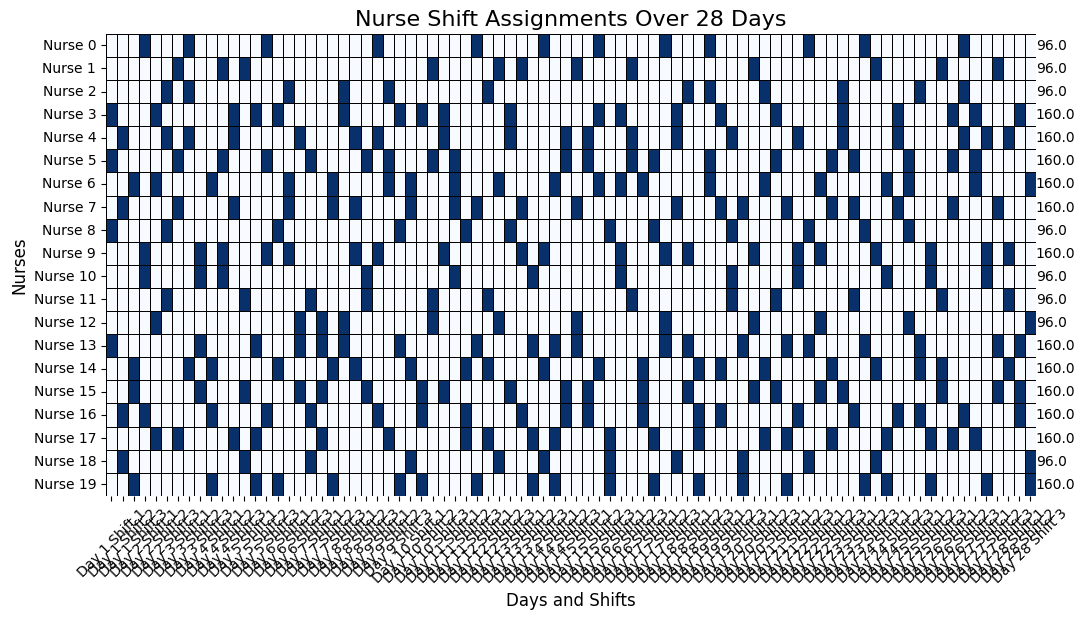

In [18]:
from ortools.sat.python import cp_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def main():
    model = cp_model.CpModel()

    # Parameters
    num_nurses = 20
    num_days = 28  # Extended to 28 days
    num_shifts = 3  # Number of shifts per day

    # Specify max shifts per nurse per week (for example, 5 for full-time, 3 for part-time)
    max_shifts_per_nurse = [3, 3, 3, 5, 5, 5, 5, 5, 3, 5, 3, 3, 3, 5, 5, 5, 5, 5, 3, 5] # Customize this list as needed

    # Creating variables
    shifts = {}
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts):
                shifts[(n, d, s)] = model.NewBoolVar(f'shift_n{n}_d{d}_s{s}')

    # Each shift must have exactly 4 nurses assigned
    for d in range(num_days):
        for s in range(num_shifts):
            model.Add(sum(shifts[(n, d, s)] for n in range(num_nurses)) == 4)  # Change to 4 nurses per shift

    # Each nurse can work at most one shift per day
    for n in range(num_nurses):
        for d in range(num_days):
            model.Add(sum(shifts[(n, d, s)] for s in range(num_shifts)) <= 1)

    # Each nurse should have at least one shift rest between two working shifts
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts - 1):
                model.Add(shifts[(n, d, s)] + shifts[(n, d, s + 1)] <= 1)

    # If a nurse works night shift (shift 2) on day d, they cannot work morning shift on day d + 1
    for n in range(num_nurses):
        for d in range(num_days - 1):
            model.Add(shifts[(n, d, 2)] + shifts[(n, d + 1, 0)] <= 1)

    # Preventing nurses from working the same shift on consecutive days
    for n in range(num_nurses):
        for d in range(num_days - 1):
            for s in range(num_shifts):
                model.Add(shifts[(n, d, s)] + shifts[(n, d + 1, s)] <= 1)

    # New constraint: Limit the total number of shifts each nurse can work per week (split into four 7-day weeks)
    for n in range(num_nurses):
        for week in range(4):
            model.Add(sum(shifts[(n, d, s)] for d in range(week * 7, (week + 1) * 7) for s in range(num_shifts)) <= max_shifts_per_nurse[n])

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Initialize heatmap data
        heatmap_data = np.zeros((num_nurses, num_days * num_shifts))

        # Calculate total hours for each nurse
        total_hours = np.zeros(num_nurses)

        # Print out the schedule for each nurse
        for n in range(num_nurses):
            print(f'Nurse {n}:')
            for d in range(num_days):
                shift_assigned = []
                for s in range(num_shifts):
                    if solver.Value(shifts[(n, d, s)]) == 1:
                        shift_assigned.append(s)
                shift_names = [f'Shift {s+1}' for s in shift_assigned]
                print(f'  Day {d+1}: {", ".join(shift_names) if shift_assigned else "Off"}')

        # Heatmap of shift assignments
        for d in range(num_days):
            print(f'Day {d + 1}:')
            for s in range(num_shifts):
                assigned_nurses = [n for n in range(num_nurses) if solver.Value(shifts[(n, d, s)]) == 1]
                print(f'  Shift {s + 1}: Nurses {assigned_nurses}')

                # Fill the heatmap data
                for nurse in assigned_nurses:
                    heatmap_data[nurse, d * num_shifts + s] = 1  # Mark the nurse as working
                    total_hours[nurse] += 8  # Each shift is 8 hours

        # Create the heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

        # Add labels
        plt.title('Nurse Shift Assignments Over 28 Days', fontsize=16)
        plt.xlabel('Days and Shifts', fontsize=12)
        plt.ylabel('Nurses', fontsize=12)
        plt.xticks(ticks=np.arange(num_days * num_shifts) + 0.5,
                   labels=[f'Day {i // 3 + 1} Shift {i % 3 + 1}' for i in range(num_days * num_shifts)],
                   rotation=45)
        plt.yticks(ticks=np.arange(num_nurses) + 0.5,
                   labels=[f'Nurse {i}' for i in range(num_nurses)],
                   rotation=0)

        # Annotate total hours worked on the heatmap
        for i in range(num_nurses):
            plt.text(num_days * num_shifts, i + 0.5, f'{total_hours[i]}', va='center', ha='left')

        plt.show()
    else:
        print('No solution found!')

if __name__ == "__main__":
    main()


In [19]:
def main():
    model = cp_model.CpModel()

    # Parameters
    num_nurses = 20
    num_days = 28  # Extended to 28 days
    num_shifts = 3  # Number of shifts per day

    # Specify max shifts per nurse per week (for example, 5 for full-time, 3 for part-time)
    max_shifts_per_nurse = [5] * num_nurses  # Max 5 shifts per week

    # Creating variables
    shifts = {}
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts):
                shifts[(n, d, s)] = model.NewBoolVar(f'shift_n{n}_d{d}_s{s}')

    # Each shift must have exactly 4 nurses assigned
    for d in range(num_days):
        for s in range(num_shifts):
            model.Add(sum(shifts[(n, d, s)] for n in range(num_nurses)) == 4)

    # Each nurse can work at most one shift per day
    for n in range(num_nurses):
        for d in range(num_days):
            model.Add(sum(shifts[(n, d, s)] for s in range(num_shifts)) <= 1)

    # Each nurse should have at least one shift rest between two working shifts
    for n in range(num_nurses):
        for d in range(num_days):
            for s in range(num_shifts - 1):
                model.Add(shifts[(n, d, s)] + shifts[(n, d, s + 1)] <= 1)

    # New constraint: Max 5 consecutive working days across weeks
    for n in range(num_nurses):
        for d in range(num_days - 4):  # Start from day 0 to day 24 (28-5)
            model.Add(sum(shifts[(n, d + i, s)] for i in range(5) for s in range(num_shifts)) <= 5)

    # Ensuring at least 2 rest days per week (7 days)
    for n in range(num_nurses):
        for week in range(4):  # There are 4 weeks
            model.Add(sum(shifts[(n, week * 7 + d, s)] for d in range(7) for s in range(num_shifts)) <= 5)  # Max 5 working days per week
            model.Add(sum(shifts[(n, week * 7 + d, s)] for d in range(7) for s in range(num_shifts)) >= 3)  # At least 2 rest days per week

    # ** New constraint: Avoid always working on weekends **
    weekend_days = [5, 6, 12, 13, 19, 20, 26, 27]  # Identify weekend days (Saturday, Sunday)
    max_weekend_shifts = 3  # For example, a nurse can work a max of 3 weekends out of 4

    for n in range(num_nurses):
        model.Add(sum(shifts[(n, d, s)] for d in weekend_days for s in range(num_shifts)) <= max_weekend_shifts)

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Initialize heatmap data
        heatmap_data = np.zeros((num_nurses, num_days * num_shifts))

        # Calculate total hours for each nurse
        total_hours = np.zeros(num_nurses)

        # Print out the schedule for each nurse
        for n in range(num_nurses):
            print(f'Nurse {n}:')
            for d in range(num_days):
                shift_assigned = []
                for s in range(num_shifts):
                    if solver.Value(shifts[(n, d, s)]) == 1:
                        shift_assigned.append(s)
                shift_names = [f'Shift {s+1}' for s in shift_assigned]
                print(f'  Day {d+1}: {", ".join(shift_names) if shift_assigned else "Off"}')

        # Heatmap of shift assignments
        for d in range(num_days):
            print(f'Day {d + 1}:')
            for s in range(num_shifts):
                assigned_nurses = [n for n in range(num_nurses) if solver.Value(shifts[(n, d, s)]) == 1]
                print(f'  Shift {s + 1}: Nurses {assigned_nurses}')

                # Fill the heatmap data
                for nurse in assigned_nurses:
                    heatmap_data[nurse, d * num_shifts + s] = 1  # Mark the nurse as working
                    total_hours[nurse] += 8  # Each shift is 8 hours

        # Create the heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

        # Add labels
        plt.title('Nurse Shift Assignments Over 28 Days', fontsize=16)
        plt.xlabel('Days and Shifts', fontsize=12)
        plt.ylabel('Nurses', fontsize=12)
        plt.xticks(ticks=np.arange(num_days * num_shifts) + 0.5,
                   labels=[f'Day {i // 3 + 1} Shift {i % 3 + 1}' for i in range(num_days * num_shifts)],
                   rotation=45)
        plt.yticks(ticks=np.arange(num_nurses) + 0.5,
                   labels=[f'Nurse {i}' for i in range(num_nurses)],
                   rotation=0)

        # Annotate total hours worked on the heatmap
        for i in range(num_nurses):
            plt.text(num_days * num_shifts, i + 0.5, f'{total_hours[i]}', va='center', ha='left')

        plt.show()
    else:
        print('No solution found!')

if __name__ == "__main__":
    main()


No solution found!
